In [1]:
import ir_datasets
import os
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
import torch
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load MSMARCO passage train dataset
dataset = ir_datasets.load('msmarco-passage/train')
docs = {}
for doc in tqdm(dataset.docs_iter(), desc="Building passage store"):
    docs[doc.doc_id] = doc.text

Building passage store: 8841823it [00:24, 354442.48it/s]


In [3]:
# Parse the run file from Zenodo
env_run_path = os.path.expanduser("zenodo/__colbert-10000-sampled-100__msmarco-passage-train-judged.run")
assert os.path.exists(env_run_path), f"Run file not found at {env_run_path}"
run_lines = open(env_run_path, 'r').read().splitlines()
# run_by_query: qid -> list of (docid, score, orig_cluster_label)
run_by_query = defaultdict(list)
for line in run_lines:
    # format: qid orig_cluster docid rank score runname
    qid, orig_cluster, docid, rank, score, _ = line.split()
    run_by_query[qid].append((docid, int(float(score)), int(orig_cluster)))
# Keep only top-100 per query
for qid in run_by_query:
    run_by_query[qid] = sorted(run_by_query[qid], key=lambda x: -x[1])[:100]

In [4]:
# extract original clusters (aligned with sorted docs)
dev_clusters = {}
test_clusters = {}
orig_clusters = {qid: [c for (_, _, c) in docs_scores]
                 for qid, docs_scores in run_by_query.items()}

In [5]:
# Split queries into dev (20%) and test (80%)
random.seed(42)
all_qids = list(run_by_query.keys())
random.shuffle(all_qids)
dev_size = int(0.2 * len(all_qids))
dev_qids = all_qids[:dev_size]
test_qids = all_qids[dev_size:]
print(f"Dev queries: {len(dev_qids)}, Test queries: {len(test_qids)}")

Dev queries: 2000, Test queries: 8000


In [21]:
from sentence_transformers import SentenceTransformer
from pyterrier_dr import RetroMAE, E5, BGEM3

# Initialize models
retro_mae_model = RetroMAE(device=device)
e5_model = E5(device=device)
bgem3_model = BGEM3(device=device)
st_model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

thresholds = [0.70, 0.72, 0.74, 0.76, 0.78, 0.80, 0.82, 0.85, 0.88, 0.90, 0.92]

# Initialize all_clusters for all encoders, thresholds, and query IDs
all_clusters = {encoder: {thr: {} for thr in thresholds} for encoder in ['retro_mae', 'e5', 'bgem3', 'st']}

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 3267.02it/s]


In [22]:
# Percorso per salvare gli embeddings
embeddings_path = "rq1/doc_embeddings.pkl"

# Funzione per salvare gli embeddings
def save_embeddings(embeddings, path):
    with open(path, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Embeddings salvati in: {path}")

# Funzione per caricare gli embeddings
def load_embeddings(path):
    with open(path, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Embeddings caricati da: {path}")
    return embeddings

# Funzione per calcolare gli embeddings per una query
def process_query(qid, docs_scores, docs, retro_mae_model, e5_model, bgem3_model, st_model):
    doc_ids = [docid for docid, _, _ in docs_scores]
    doc_texts = [docs[docid] for docid in doc_ids]

    # Calcola gli embeddings
    retro_mae_embeds = retro_mae_model.encode_docs(doc_texts)
    e5_embeds = e5_model.encode_docs(doc_texts)
    bgem3_embeds = bgem3_model.encode_docs(doc_texts)
    st_embeds = st_model.encode(doc_texts)

    return qid, {
        "retro_mae": retro_mae_embeds,
        "e5": e5_embeds,
        "bgem3": bgem3_embeds,
        "st": st_embeds
    }

# Controlla se gli embeddings esistono
if os.path.exists(embeddings_path):
    print("Caricamento degli embeddings esistenti...")
    doc_embeddings = load_embeddings(embeddings_path)
else:
    print("Calcolo degli embeddings...")

    # Organizza i risultati in un dizionario
    doc_embeddings = {
        "retro_mae": {},
        "e5": {},
        "bgem3": {},
        "st": {}
    }

    for qid, docs_scores in tqdm(run_by_query.items(), desc="Processing queries"):
        qid, embeddings = process_query(qid, docs_scores, docs, retro_mae_model, e5_model, bgem3_model, st_model)
        for model_name in doc_embeddings:
            if qid not in doc_embeddings[model_name]:
                doc_embeddings[model_name][qid] = {}
            doc_ids = [docid for docid, _, _ in docs_scores]
            for docid, emb in zip(doc_ids, embeddings[model_name]):
                doc_embeddings[model_name][qid][docid] = emb

    save_embeddings(doc_embeddings, embeddings_path)

Caricamento degli embeddings esistenti...
Embeddings caricati da: rq1/doc_embeddings.pkl


In [23]:
# Perform clustering and collect cluster assignments per threshold
for encoder, qid_dict in doc_embeddings.items():
    print(f"Clustering with {encoder} embeddings...")
    for qid, docs_scores in tqdm(list(run_by_query.items()), desc=f"Clustering queries with encoder {encoder}"):
        doc_ids = [d for d, _, _ in docs_scores]
        assert all(docid in qid_dict[qid] for docid in doc_ids), f"Missing embedding in encoder={encoder}, qid={qid}"

        # Ottieni l'embedding di ciascun docid per la query qid
        embeddings = np.array([
            qid_dict[qid][docid] for docid in doc_ids if docid in qid_dict[qid]
        ])

        for thr in thresholds:
            clustering = AgglomerativeClustering(
                n_clusters=None,
                metric='cosine',
                linkage='complete',
                distance_threshold=1 - thr
            )
            labels = clustering.fit_predict(embeddings)
            all_clusters[encoder][thr][qid] = labels.tolist()

Clustering with retro_mae embeddings...


Clustering queries with encoder retro_mae: 100%|██████████| 10000/10000 [03:23<00:00, 49.24it/s]


Clustering with e5 embeddings...


Clustering queries with encoder e5: 100%|██████████| 10000/10000 [03:20<00:00, 49.95it/s]


Clustering with bgem3 embeddings...


Clustering queries with encoder bgem3: 100%|██████████| 10000/10000 [04:19<00:00, 38.53it/s]


Clustering with st embeddings...


Clustering queries with encoder st: 100%|██████████| 10000/10000 [02:04<00:00, 80.53it/s]


In [24]:
from sklearn.preprocessing import minmax_scale

# Select best threshold on dev set using internal metrics (silhouette)
best_thresholds = {}
all_results = []

for encoder, clusters_by_threshold in all_clusters.items():
    print(f"Selecting best threshold for encoder: {encoder}")
    sil_avgs = {}
    ch_avgs = {}
    for thr in thresholds:
        sil_scores = []
        ch_scores = []
        for qid in dev_qids:
            labels = np.array(clusters_by_threshold[thr][qid])
            if len(set(labels)) > 1:
                doc_ids = [d for d, _, _ in run_by_query[qid]]
                
                emb = np.array([
                    doc_embeddings[encoder][qid][docid]
                    for docid in doc_ids
                    if docid in doc_embeddings[encoder][qid]
                ])
                
                # Calcola lo score solo se hai abbastanza embedding
                if len(emb) == len(labels):
                    sil_scores.append(silhouette_score(emb, labels, metric='cosine'))
                    ch_scores.append(calinski_harabasz_score(emb, labels))
        sil_avgs[thr] = np.mean(sil_scores) if sil_scores else -1.0
        ch_avgs[thr] = np.mean(ch_scores) if ch_scores else -1.0
    
    # Normalize scores
    sil_norm = minmax_scale([sil_avgs[thr] for thr in thresholds])
    ch_norm = minmax_scale([ch_avgs[thr] for thr in thresholds])
    combined_scores = sil_norm + ch_norm


    for i, thr in enumerate(thresholds):
        all_results.append({
            'encoder': encoder,
            'threshold': thr,
            'silhouette_avg': sil_avgs[thr],
            'calinski_harabasz_avg': ch_avgs[thr],
            'combined_score': combined_scores[i]
        })

    best_thr = thresholds[np.argmax(combined_scores)]
    best_thresholds[encoder] = best_thr

    print(f"Best threshold for {encoder}: {best_thr} "
        f"(Silhouette: {sil_avgs[best_thr]:.4f}, "
        f"Calinski-Harabasz: {ch_avgs[best_thr]:.2f})")
    
df_all = pd.DataFrame(all_results)
df_all


Selecting best threshold for encoder: retro_mae
Best threshold for retro_mae: 0.9 (Silhouette: 0.2583, Calinski-Harabasz: 10.23)
Selecting best threshold for encoder: e5
Best threshold for e5: 0.92 (Silhouette: 0.2919, Calinski-Harabasz: 7.10)
Selecting best threshold for encoder: bgem3
Best threshold for bgem3: 0.88 (Silhouette: 0.2854, Calinski-Harabasz: 10.04)
Selecting best threshold for encoder: st
Best threshold for st: 0.85 (Silhouette: 0.2916, Calinski-Harabasz: 11.43)


,encoder,threshold,silhouette_avg,calinski_harabasz_avg,combined_score
0,retro_mae,0.70,0.233340,4.950234,0.000000
1,retro_mae,0.72,0.239947,4.997737,0.189064
2,retro_mae,0.74,0.245810,5.092865,0.363822
3,retro_mae,0.76,0.251888,5.223333,0.549200
4,retro_mae,0.78,0.257979,5.417000,0.743263
5,retro_mae,0.80,0.263091,5.708427,0.923135
6,retro_mae,0.82,0.266862,6.127910,1.082806
7,retro_mae,0.85,0.269484,7.062135,1.278571
8,retro_mae,0.88,0.265850,8.634892,1.385479
9,retro_mae,0.90,0.258348,10.227179,1.387956


In [25]:
# Evaluate selected threshold on test set (internal metrics)
results = []

for encoder, best_thr in best_thresholds.items():
    labels_test = all_clusters[encoder][best_thr]
    sil_scores, ch_scores = [], []
    for qid in test_qids:
        labels = np.array(labels_test[qid])
        if len(set(labels)) > 1:
            doc_ids = [d for d, _, _ in run_by_query[qid]]

            emb = np.array([
                doc_embeddings[encoder][qid][docid]
                for docid in doc_ids
                if docid in doc_embeddings[encoder][qid]
            ])
            
            if len(emb) == len(labels):  # Verifica che il numero di embedding corrisponda alle label
                sil_scores.append(silhouette_score(emb, labels, metric='cosine'))
                ch_scores.append(calinski_harabasz_score(emb, labels))
    
    avg_silhouette = np.mean(sil_scores) if sil_scores else -1.0
    avg_calinski_harabasz = np.mean(ch_scores) if ch_scores else -1.0
    results.append({
        'encoder': encoder, 
        'threshold': best_thr, 
        'avg_silhouette': avg_silhouette,
        'avg_calinski_harabasz': avg_calinski_harabasz
        })
    
df_results = pd.DataFrame(results)

if len(df_results) > 1:
    sil_norm = minmax_scale(df_results['avg_silhouette'])
    ch_norm = minmax_scale(df_results['avg_calinski_harabasz'])
    df_results['combined_score'] = sil_norm + ch_norm
else:
    df_results['combined_score'] = df_results['avg_silhouette'] + df_results['avg_calinski_harabasz']

df_results

,encoder,threshold,avg_silhouette,avg_calinski_harabasz,combined_score
0,retro_mae,0.90,0.255388,10.213800,0.731408
1,e5,0.92,0.291616,7.068144,1.000000
2,bgem3,0.88,0.284157,10.030566,1.482904
3,st,0.85,0.289375,11.368969,1.938125


In [26]:
# 9. Save run files for test set only: original and best threshold
os.makedirs("rq1", exist_ok=True)

for encoder, best_thr in best_thresholds.items():
    print(f"Saving run file for encoder {encoder} with threshold {best_thr}")
    labels_test = all_clusters[encoder][best_thr]
    tag = f"run_{encoder}_thr_{int(best_thr*100)}"
    run_fname = f"rq1/{tag}_test.run"
    with open(run_fname, 'w') as fout:
        for qid in test_qids:
            docs_scores = run_by_query[qid]
            labels = labels_test[qid]
            for rank_idx, (docid, score, orig_c) in enumerate(docs_scores, start=1):
                fout.write(f"{qid} {labels[rank_idx-1]} {docid} {rank_idx} {score} {tag}\n")
    print(f"Saved test run file: {run_fname}")

print("Run files saved for all encoders with best thresholds.")


Saving run file for encoder retro_mae with threshold 0.9
Saved test run file: rq1/run_retro_mae_thr_90_test.run
Saving run file for encoder e5 with threshold 0.92
Saved test run file: rq1/run_e5_thr_92_test.run
Saving run file for encoder bgem3 with threshold 0.88
Saved test run file: rq1/run_bgem3_thr_88_test.run
Saving run file for encoder st with threshold 0.85
Saved test run file: rq1/run_st_thr_85_test.run
Run files saved for all encoders with best thresholds.


---

/opt/miniconda3/envs/emalir/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/miniconda3/envs/emalir/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/miniconda3/envs/emalir/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/miniconda3/envs/emalir/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/opt/miniconda3/envs/emalir/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/miniconda3/envs/emalir/lib/python3.10/site-package

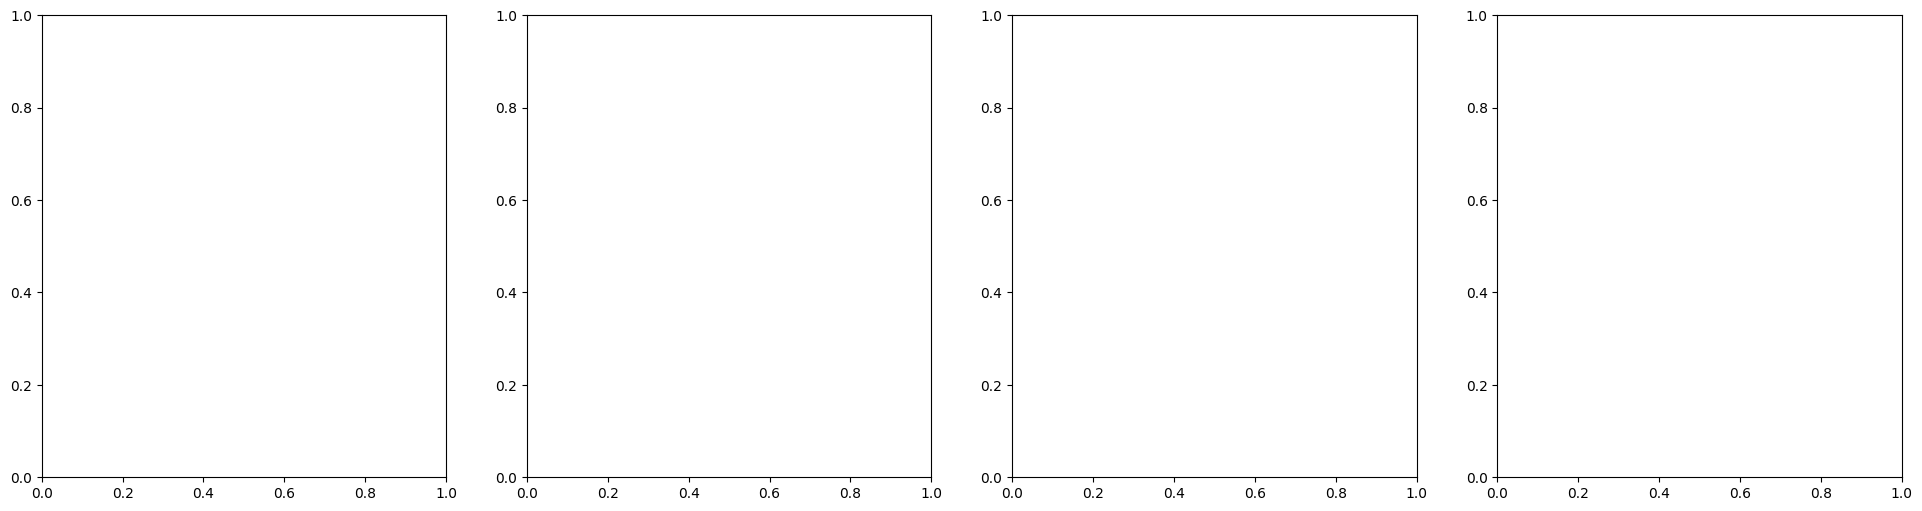

In [27]:
import numpy as np
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import umap.umap_ as umap

qid = dev_qids[0]  # Scegli una query da visualizzare
encoders = ['retro_mae', 'e5', 'bgem3', 'st']
fig, axes = plt.subplots(1, len(encoders), figsize=(6*len(encoders), 6), sharex=False, sharey=False)
label_encoder = LabelEncoder()

for idx, encoder in enumerate(['retro_mae', 'e5', 'bgem3', 'st']):
    thr = best_thresholds[encoder]  # Scegli il threshold migliore per l'encoder
    doc_ids = [d for d, _, _ in run_by_query[qid]]
    embeddings = np.array([
        doc_embeddings[encoder][qid][docid] for docid in doc_ids if docid in doc_embeddings[encoder][qid]
    ])
    labels = np.array(all_clusters[encoder][thr][qid])
    labels = label_encoder.fit_transform(labels)  # Codifica le etichette numeriche
    texts = [docs[docid] for docid in doc_ids if docid in doc_embeddings[encoder][qid]]

    # Riduzione con UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
    embedding_3d = reducer.fit_transform(embeddings)

    # Costruzione DataFrame
    df_plot = pd.DataFrame({
        'x': embedding_3d[:, 0],
        'y': embedding_3d[:, 1],
        'z': embedding_3d[:, 2],
        'cluster': labels,
        'doc_id': doc_ids[:len(embedding_3d)],
        'text': texts[:len(embedding_3d)]
    })

    # Plotly interactive scatter plot
    fig = px.scatter_3d(
    df_plot, x='x', y='y', z='z',
    color=df_plot['cluster'].astype(str),
    hover_data=['doc_id', 'text'],
    title=f'Visualizzazione 3D dei Cluster - Query {qid} - Encoder {encoder}',
    color_discrete_sequence=px.colors.qualitative.Bold
    )
    fig.update_traces(marker=dict(size=5))
    fig.show()
#     # Visualizzazione
#     ax = axes[idx]
#     scatter = ax.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap='hsv', s=50)
#     ax.set_title(f'Encoder: {encoder}')
#     ax.set_xlabel('Dim 1')
#     ax.set_ylabel('Dim 2')
#     fig.colorbar(scatter, ax=ax, label='Cluster')

# plt.suptitle(f'Visualizzazione dei Cluster per la Query {qid}', fontsize=16)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()